In [1]:
import argparse
import cv2
import numpy as np
import networkx as nx
import os
from itertools import combinations
from collections import defaultdict
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import Compose
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from viz_3d import *

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d

import pypose as pp

from SLAM.TUM_dataset import TUMVisualInertialDataset

import pytorch3d

os.chdir("./DepthAnything/")
from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

In [32]:
from pytorch3d.renderer.fisheyecameras import FishEyeCameras
from scipy.spatial.transform import Rotation as R

In [54]:
x = torch.arange(0, 512, 20)
y = torch.arange(0, 512, 20)
xx, yy = torch.meshgrid(x, y)

# Reshape to shape (N, 2)
xy = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# Add a column of ones to make it shape (N, 3)
xy1 = torch.cat([xy, torch.ones(xy.shape[0], 1)], dim=1)

tensor([[  0.,   0.,   1.],
        [  0.,  20.,   1.],
        [  0.,  40.,   1.],
        ...,
        [500., 460.,   1.],
        [500., 480.,   1.],
        [500., 500.,   1.]])

In [57]:
Rot = R.random().as_matrix()

print(Rot)
cam = FishEyeCameras(
    focal_length=torch.tensor([190.97847715128717]).repeat(2, 1),
    principal_point=torch.tensor([[254.93170605935475, 256.8974428996504]]),
    radial_params=torch.tensor(
        [
            [
                0.373004838186,
                0.372994740336,
                0.498890050897,
                0.502729380663,
                0.00348238940225,
                0.000715034845216,
            ]
        ]
    ),
    # tangential_params=tensor([[0., 0.]]),
    # thin_prism_params=tensor([[0., 0., 0., 0.]]),
    R=torch.tensor([Rot]),
    T=torch.tensor([[10.0, 20.0, 0.0]]),
    world_coordinates=True,
    use_radial=True,
    use_tangential=False,
    use_thin_prism=False,
    device="cpu",
    image_size=(512, 512),
)

out = cam.unproject_points(xy1, world_coordinates=True, scaled_depth_input=False)

[[ 0.14225    -0.49222114  0.85876847]
 [-0.77237671  0.48738581  0.4072951 ]
 [-0.61903082 -0.72123049 -0.31084951]]


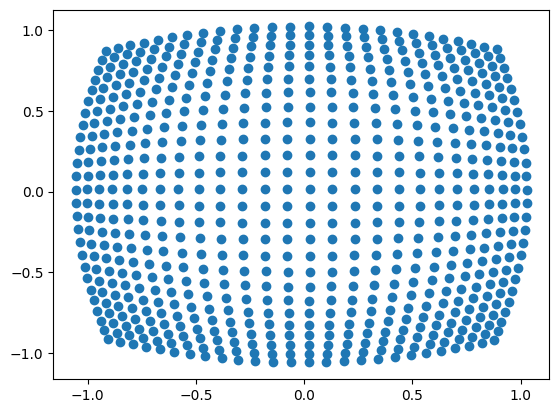

In [59]:
plt.scatter(*out[:, :2].numpy().T)

### Initialize Dataset

(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
torch.Size([10, 518, 518, 3]) torch.Size([988]) torch.Size([988, 3]) torch.Size([988, 3]) torch.Size([10, 7])


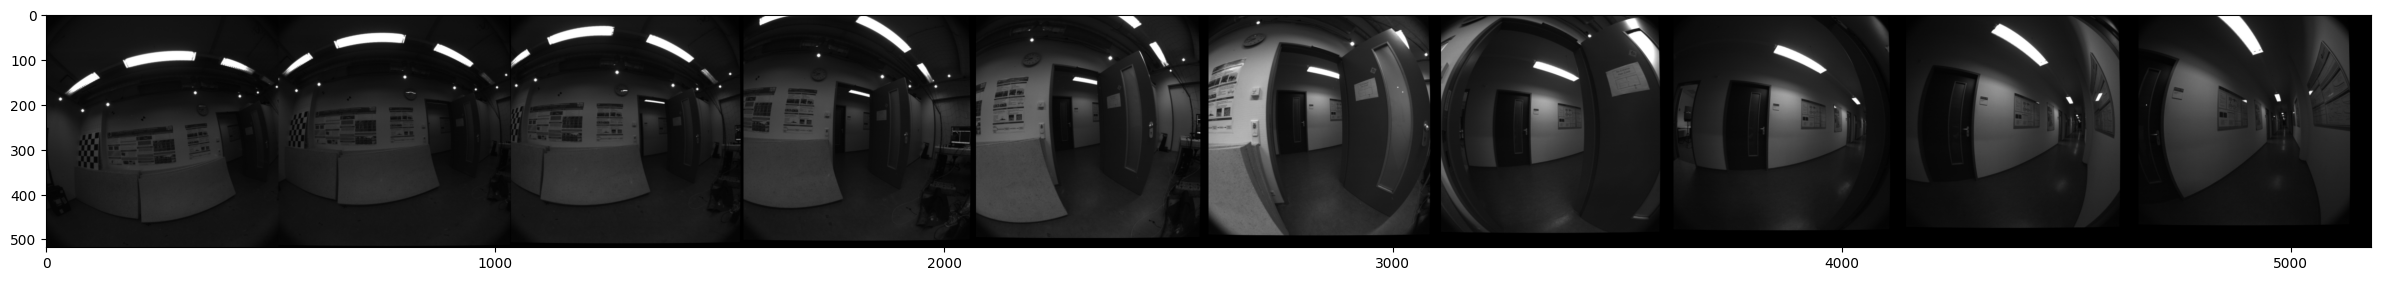

In [2]:
transform = Compose(
    [
        Resize(
            width=518,
            height=518,
            resize_target=False,
            keep_aspect_ratio=True,
            ensure_multiple_of=14,
            resize_method="lower_bound",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        # NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # PrepareForNet(),  # this makes the image (and training masks) contiguous and floats
    ]
)

seq_len = 10

dataset = TUMVisualInertialDataset(
    path="../datasets/dataset-corridor4_512_16/dso",
    transforms=transform,
    sequence_length=seq_len,
    skip_frames=10,
)


X = dataset[50]


print(X["cam0"].shape, X["dt"].shape, X["acc"].shape, X["gyro"].shape, X["gt_pose"].shape)


s, h, w, c = X["cam0"].shape


plt.figure(figsize=(30, 10))


plt.imshow(np.concatenate(tuple(X["cam0"]), axis=1))

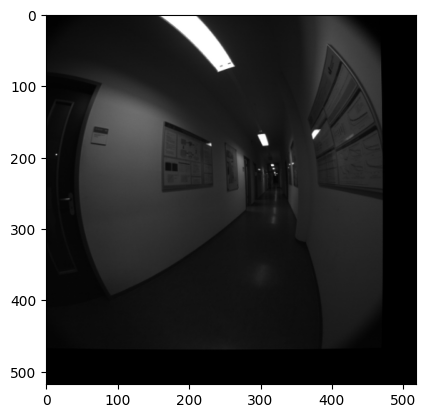

In [3]:
plt.imshow(X["cam1"][-1])

### Initialize Models

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# Depth Anything
depth_anything = DepthAnything.from_pretrained("LiheYoung/depth_anything_vitb14").to(device).eval()
total_params = sum(param.numel() for param in depth_anything.parameters())
print("DepthAnything parameters: {:.2f}M".format(total_params / 1e6))

# Extractor and matcher
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

cuda


A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\Users\pajul\anaconda3\envs\matine\lib\site-packages\xformers\__init__.py", line 55, in _is_triton_available
    from xformers.triton.softmax import softmax as triton_softmax  # noqa
  File "c:\Users\pajul\anaconda3\envs\matine\lib\site-packages\xformers\triton\softmax.py", line 11, in <module>
    import triton
ModuleNotFoundError: No module named 'triton'


DepthAnything parameters: 97.47M


In [5]:
def DepthAnythingProcess(batch):
    batch = batch.permute(0, 3, 1, 2)  # [B, C, W, H]
    mean = torch.tensor([0.485, 0.456, 0.406], device=batch.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=batch.device).view(1, 3, 1, 1)
    batch = (batch - mean) / std
    batch = batch.contiguous()
    return batch


for i, data in enumerate(dataset):
    image_batch = data["cam0"].to(device)
    # features = extract_keypoints(data['cam0'], extractor, device)
    image_batch = DepthAnythingProcess(image_batch)

    with torch.no_grad():
        depth = depth_anything(image_batch)
        print(depth.shape)

    # depth = F.interpolate(depth[None], (h, w), mode="bilinear", align_corners=False)[0, 0]

    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    break

(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
(512, 512, 3)
(512, 512, 3)
0 0 511 511
(511, 511, 3)
(518, 518, 3)
torch.Size([10, 518, 518])


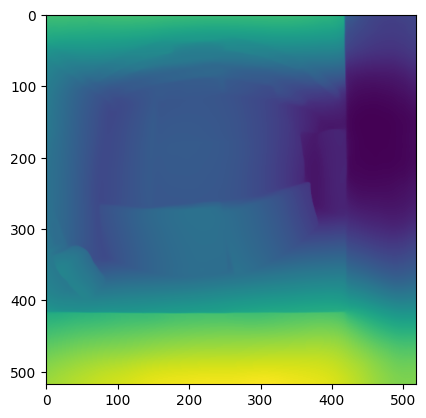

In [6]:
plt.imshow(depth[-1].cpu().numpy())